# Workshop CentraleSupélec - CeSIA - Partie 3

- Création : 02/2025 par [Nicolas Guillard](mailto:nicolas.guillar@securite-ia.fr) - bénévole au [CeSIA](https://www.securite-ia.fr/).

Créer en s'inspirant particulièrement de [Générer des noms de villes et communes françaises](https://github.com/alxndrTL/villes) par [Alexandre TL](https://www.youtube.com/@alexandretl)


## Présentation du sujet et Plan

## Indications

Les éléments de ce TP :
- le présent carnet,
  
(et ceux qui seront installés grâce au script `Installation de l'environnement de travail`),
- le répertoire `./utils` et les fichiers contenus,
- le répertoire `./weights` contenant les poids des modèles utiles et ceux produits,
- le répertoire `./images` contenant les illustrations des carnets,
- le fichier de données `./villes.txt`.

## Installation de l'environnement de travail

Le script ci-dessous est destiné à installer les éléments nécessaires au fonctionnement de ce carnet.

In [1]:
import sys
from pathlib import Path

IN_COLAB = "google.colab" in sys.modules

repo = "workshop_cs_202503"
branch = "main"
url_repo = f"https://github.com/nicolasguillard/{repo}/archive/refs/heads/{branch}.zip"
target_dir = (
  "/content"
  if IN_COLAB
  else "."
)
resources = ["utils", "weights", "images", "villes.txt"]

if not Path(f"{target_dir}/utils").exists() :
  print("=== Installation des ressources utiles à ce carnet ===")
  !wget -P {target_dir} {url_repo}
  !unzip {target_dir}/{branch}.zip -d {target_dir}
  for resource in resources:
    !mv {target_dir}/{repo}-{branch}/{resource} {target_dir}/{resource}
  !rm -rf {target_dir}/{repo}-{branch}
  !rm -f {target_dir}/{branch}.zip
  print("=== Terminé ===")

  if IN_COLAB:
    print("--- Rafraichissez au besoin la liste des fichiers à gauche si nécessaire ---")
else:
  print("Il semble que des ressources nécessaires pour ce carnet soient déjà installés :")
  for resource in resources:
    print("\t", f"./{resource}", "présent" if Path(f"{target_dir}/{resource}").exists else "absent")
  print("Pour supprimer les ressources automatiquement installées, utilisez la fonction 'remove_resources()' dans un autre bloc de code.")

def remove_resources():
  !rm -rf {target_dir}/{repo}-{branch}
  for resource in resources:
    !rm -rf {target_dir}/{resource}

Il semble que des ressources nécessaires pour ce carnet soient déjà installés :
	 ./utils présent
	 ./weights présent
	 ./images présent
	 ./villes.txt présent
Pour supprimer les ressources automatiquement installées, utilisez la fonction 'remove_resources()' dans un autre bloc de code.


## Les modules et paramétrages globaux

Tous les modules nécessaires sont importés. A moins d'un besoin spécifique, il n'y aura pas besoin de modifier le bloc de code suivant.

In [2]:
# Modules prédéfinis et tiers
import datetime
from typing import Tuple

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from tqdm.notebook import trange, tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

In [3]:
#Modules créés pour le projet
from utils import get_datasets, SOS, EOS, PAD
from utils import print_color, load_transformer_model, TransformerConfig, LanguageModel
from utils import clean_memory

### Device

Sélection du GPU selon l'environnement de travail

In [4]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using mps device


### Paramétrages

In [5]:
# Retirer la limite du nombre maximal de lignes affichées dans un tableau pandas
pd.set_option('display.max_rows', None) 

In [6]:
# Configurer le thème de seaborn
sns.set_theme(style="whitegrid")

In [7]:
# Paramétrer les graines aléatoires
#pth_rnd_gen_device = torch.Generator(device).manual_seed(42)
if device == "cuda":
    pth_rnd_gen_device = torch.cuda.manual_seed(42)
elif device == "mps":
    pth_rnd_gen_device = torch.mps.manual_seed(42)
pth_rnd_gen_cpu = torch.manual_seed(42)
pth_rnd_gen = pth_rnd_gen_cpu if device == "cpu" else pth_rnd_gen_device

## Interprétabilité

### Recherche de concepts avec l'utilisation d'un SAE

#### Le principe

Afin de séparer et de distinguer les possibles caractéristiques instriquées dans des neurones polysémantiques, nous allons utiliser un Sparse Auto-Encoder.

![](https://drive.google.com/uc?id=1_Y3mIiTL1RgQ5nXMgyxBG7SIz5PfGXWz)

![Utilisation du SAE](./images/sae_with_model.png)

Il s'agira donc de récupérer les activations fournies par une (la par défaut) couche `DecodeLaeyr` dans le modèle de langue `LanguageModel` et de s'en servir d'abord pour l'entrainement du SAE, puis pour l'interprétation des caractéristiques apprises (en espérant que les neurones de la couche cachée soient surtout monosémantiques).

#### Définition d'un modèle de SAE

Le Sparse auto-encoder est donc composé d'une couche cachée qu'on appelera "activations cachées du SAE". Il prend en entrée les activations générée par un module `DecoderLayer`. Voici un schéma :

![](https://drive.google.com/uc?id=1Txvhbzkrp7aKlFnZ62ANAeqW7JdXHTuA)

![SAE](./images/sae.png)

avec `nb_caract` le nombre de caractéristiques à distinguer et `d_model` la dimension interne au modèle de langue.

Mathématiquement, son fonctionnement peut-être exprimé ainsi :

$\text{encode}(x) = \text{ReLU}((x - b_{\text{dec}}) \ @ \ W_{\text{enc}} + b_{\text{enc}})$

et

$\text{decode}(h) = h \ @ \ W_{\text{dec}} + b_{\text{dec}}$

avec :

- $@$ : multiplication matricielle


> Conseil(s) :
> - $W_{\text{enc}}$, $W_{\text{dec}}$, $b_{\text{dec}}$ et $b_{\text{enc}}$ sont des instances de la classe `nn.Parameter`;
> - la création des instances $W_{\text{enc}}$ et $W_{\text{dec}}$ prend pour paramètre un tenseur vide qui est initialisé avec la fonction `torch.nn.init.kaiming_uniform_`;
> - la création des instances $b_{\text{dec}}$ et $b_{\text{enc}}$ prend pour paramètre un tenseur replis de zéros;
> - se rappeler que les dimensions de `x` seront (batch, séquence taille de la sortie d'un `DecoderLayer`);
> - se rappeler que les dimensions de la sortie du SAE seront aussi (batch, séquence taille de la sortie d'un `DecoderLayer`);


##### EXERCICE(S) : Définition de la classe d'auto-encodeur

Compléter les méthodes d'initialisation `__init()`, `encode()` et `decode()` à partir des explications fournies précédemment :

<details> 
<summary>Eléments d'énoncé</summary>

```python
class AutoEncoder(nn.Module):
    def __init__(self, act_size: int, num_features: int, l1_coeff: float) -> None:
        super().__init__()

        self.l1_coeff = l1_coeff
        self.num_features = num_features

        self.W_enc = None  ### EXERCICE : remplacer None par les bonnes instructions
        self.b_enc = None  ### EXERCICE : remplacer None par les bonnes instructions

        self.W_dec = None  ### EXERCICE : remplacer None par les bonnes instructions
        self.b_dec = None  ### EXERCICE : remplacer None par les bonnes instructions

        self.W_dec.data[:] = self.W_dec / self.W_dec.norm(dim=-1, keepdim=True)
    
    def encode(self, x: torch.Tensor) -> torch.Tensor:
        ### EXERCICE : compléter ce bloc avec les bonnes instructions 
        # DEBUT DE BLOC
        ### EXERCICE : à compléter
        return None  ### EXERCICE : remplacer None par les bonnes instructions
        # FIN DE BLOC
    
    def decode(self, x: torch.Tensor) -> torch.Tensor:
        ### EXERCICE : compléter ce bloc avec les bonnes instructions 
        # DEBUT DE BLOC
        ### EXERCICE : à compléter
        return None  ### EXERCICE : remplacer None par les bonnes instructions
        # FIN DE BLOC

    def reconstruct_loss(self, x: torch.Tensor, acts: torch.Tensor, x_reconstruct: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        l2_loss = (x_reconstruct.float() - x.float()).pow(2).sum(-1).mean(0) # loss de reconstruction MSE
        l1_loss = self.l1_coeff * (acts.float().abs().sum()) # penalité L1 sur les activations des concepts
        return l1_loss, l2_loss
    
    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor] :
        """
        Args :
            x : input (B, S, act_size = d_model) ou (B*S, act_size = d_model)
        """
        hidden_acts = None  ### EXERCICE : remplacer None par les bonnes instructions
        x_reconstruct = None  ### EXERCICE : remplacer None par les bonnes instructions

        l1_loss, l2_loss = self.reconstruct_loss(x, hidden_acts, x_reconstruct)
        loss = l2_loss + l1_loss # loss total

        return loss, x_reconstruct, hidden_acts, l2_loss, l1_loss
    
    # permet de stabiliser l'entraînement
    @torch.no_grad()
    def make_decoder_weights_and_grad_unit_norm(self):
        W_dec_normed = self.W_dec / self.W_dec.norm(dim=-1, keepdim=True)
        W_dec_grad_proj = (self.W_dec.grad * W_dec_normed).sum(-1, keepdim=True) * W_dec_normed
        self.W_dec.grad -= W_dec_grad_proj
        # Bugfix(?) for ensuring W_dec retains unit norm, this was not there when I trained my original autoencoders.
        self.W_dec.data = W_dec_normed
````
</details>

 > Solution(s) :

In [8]:
class AutoEncoder(nn.Module):
    def __init__(self, act_size: int, num_features: int, l1_coeff: float) -> None:
        super().__init__()

        self.l1_coeff = l1_coeff
        self.num_features = num_features

        self.W_enc = nn.Parameter(torch.nn.init.kaiming_uniform_(torch.empty(act_size, num_features))) ### EXERCICE : remplacer None par les bonnes instructions
        self.b_enc = nn.Parameter(torch.zeros(num_features)) ### EXERCICE : remplacer None par les bonnes instructions

        self.W_dec = nn.Parameter(torch.nn.init.kaiming_uniform_(torch.empty(num_features, act_size))) ### EXERCICE : remplacer None par les bonnes instructions
        self.b_dec = nn.Parameter(torch.zeros(act_size)) ### EXERCICE : remplacer None par les bonnes instructions

        self.W_dec.data[:] = self.W_dec / self.W_dec.norm(dim=-1, keepdim=True)
    
    def encode(self, x: torch.Tensor) -> torch.Tensor:
        ### EXERCICE : compléter ce bloc avec les bonnes instructions 
        # DEBUT DE BLOC
        ### EXERCICE : à compléter
        x_cent = x - self.b_dec
        return F.relu(x_cent @ self.W_enc + self.b_enc) # calcul des activations des concepts
        # FIN DE BLOC
    
    def decode(self, x: torch.Tensor) -> torch.Tensor:
        ### EXERCICE : compléter ce bloc avec les bonnes instructions 
        # DEBUT DE BLOC
        ### EXERCICE : à compléter
        return x @ self.W_dec + self.b_dec # calcul de la reconstruction
        # FIN DE BLOC

    def reconstruct_loss(self, x: torch.Tensor, acts: torch.Tensor, x_reconstruct: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        l2_loss = (x_reconstruct.float() - x.float()).pow(2).sum(-1).mean(0) # loss de reconstruction MSE
        l1_loss = self.l1_coeff * (acts.float().abs().sum()) # penalité L1 sur les activations des concepts
        return l1_loss, l2_loss
    
    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor] :
        """
        Args :
            x : input (B, S, act_size = d_model) ou (B*S, act_size = d_model)
        """
        hidden_acts = self.encode(x) ### EXERCICE : remplacer None par les bonnes instructions
        x_reconstruct = self.decode(hidden_acts) ### EXERCICE : remplacer None par les bonnes instructions

        l1_loss, l2_loss = self.reconstruct_loss(x, hidden_acts, x_reconstruct)
        loss = l2_loss + l1_loss # loss total

        return loss, x_reconstruct, hidden_acts, l2_loss, l1_loss
    
    # permet de stabiliser l'entraînement
    @torch.no_grad()
    def make_decoder_weights_and_grad_unit_norm(self):
        W_dec_normed = self.W_dec / self.W_dec.norm(dim=-1, keepdim=True)
        W_dec_grad_proj = (self.W_dec.grad * W_dec_normed).sum(-1, keepdim=True) * W_dec_normed
        self.W_dec.grad -= W_dec_grad_proj
        # Bugfix(?) for ensuring W_dec retains unit norm, this was not there when I trained my original autoencoders.
        self.W_dec.data = W_dec_normed

#### EXERCICE(S) : Adaptation de la définition du Transformer

Il faut modifier la méthode de propagation `forward()` de la classe `AutoEncoder` afin de récupérer les activations de la couche cachée si le paramètre `act`vaut `True`. Pour cela, on va créer une classe `AutoEncoderForSAE` qui héritera de l'ensemble des éléments de la classe parent, et qui disposera de la méthode `forward()` avec des modifications à apporter, selon les explications fournies.

> Conseil(s) :
> - prendre en considération la définition de la méthode `forward()` de la classe `Transformer`;
> - il s'agit donc d'intercepter le résultat d'un calcul intermédiaire réalisé durant la propagation avec la classe `LanguageModel`.

<details> 
<summary>Eléments d'énoncé</summary>

```python
class LanguageModelForSAE(LanguageModel):
    def __init__(self, model_config: TransformerConfig) -> None:
        super().__init__(model_config)

    def forward(self, tokens: torch.Tensor, act: bool = False, stop_at_layer: int = None) -> torch.Tensor:
        """
        Args :
            tokens (torch.Tensor) : input shaped (B, s, vocab_size) with s in [1; S]
            act (bool) : if True, return hidden activation (the last layer by default, if stop_at_layer not provided)
            stop_at_layer (int) : return the ouput (activations) after the specified {layer}-th layer (1 -> n_layers)
        """
        act = act or (stop_at_layer != None)
        
        ### EXERCICE : compléter ce bloc avec les bonnes instructions 
        # DEBUT DE BLOC
        ### EXERCICE : à compléter
        return None  ### EXERCICE : remplacer None par les bonnes instructions
        # FIN DE BLOC
````
</details>

> Solution(s) :

In [9]:
class LanguageModelForSAE(LanguageModel):
    def __init__(self, model_config: TransformerConfig) -> None:
        super().__init__(model_config)

    def forward(self, tokens: torch.Tensor, act: bool = False, stop_at_layer: int = -1) -> torch.Tensor:
        """
        Args :
            - tokens (torch.Tensor) : input shaped (B, s, vocab_size) with s in [1; S]
            - act (bool) : return hidden activations if True
            - stop_at_layer (int) : the indice of the DecoderLayer module to take output
        """
        x = self.embedding(tokens)
        x = self.core(x, stop_at_layer=stop_at_layer)

        if act:
            return x #(B, S, d_model)
        
        logits = self.get_logits_(x)

        return logits #(B, S, vocab_size)

#### La phase d'entrainement du SAE

##### Les hyperparamètres

Les hyperparamètres fournis pour la création du SAE et son entrainement :

In [10]:
d_model = 32 # dimension du modèle
n_heads = 4 # nombre de têtes pour l'attention
n_layers = 1 # nombre de couches
dropout = 0.

epochs = 5
batch_size = 16
print_every = 100

##### Les jeux de données

In [11]:
train_dataset, test_dataset, tokenizer, _ = get_datasets("./villes.txt")

creating vocabulary:   0%|          | 0/46 [00:00<?, ?it/s]

creatind dataset:   0%|          | 0/32926 [00:00<?, ?it/s]

creatind dataset:   0%|          | 0/3659 [00:00<?, ?it/s]

##### Chargement du modèle de langue

Chargement des poids du modèle appris dans la partie 2, ou sinon le fichier `./weights/solutions/model_32__4_heads__1_layers.pth` en remplacement si besoin.

In [12]:
config = TransformerConfig(
    vocab_size=tokenizer.vocabulary_size(),
    d_model=d_model,
    n_heads=n_heads,
    n_layers=n_layers,
    dropout=dropout,
    max_len=max(train_dataset.max_len, test_dataset.max_len) - 1  # Because X and y : sequence[:-1] and sequence[1:] in dataset
)

filename = "./weights/model_32__4_heads__1_layers.pth" # A modifier selon le contexte
#filename = "`./weights/solutions/model_32__4_heads__1_layers.pth`" # A décommenter selon le contexte
model = load_transformer_model(filename, class_model=LanguageModelForSAE, config=config, device=device)

LanguageModelForSAE(
  (embedding): Embedding(46, 32, padding_idx=0)
  (core): Transformer(
    (PE): Embedding(46, 32)
    (in_dropout): Dropout(p=0.0, inplace=False)
    (layers): ModuleList(
      (0): DecoderLayer(
        (attention_norm): RMSNorm()
        (sa): SelfAttentionMultiHead(
          (query_proj): Linear(in_features=32, out_features=32, bias=False)
          (key_proj): Linear(in_features=32, out_features=32, bias=False)
          (value_proj): Linear(in_features=32, out_features=32, bias=False)
          (c_proj): Linear(in_features=32, out_features=32, bias=False)
          (attn_dropout): Dropout(p=0.0, inplace=False)
          (resid_dropout): Dropout(p=0.0, inplace=False)
        )
        (mlp_norm): RMSNorm()
        (mlp): MLP(
          (fc_1): Linear(in_features=32, out_features=128, bias=False)
          (fc_2): Linear(in_features=128, out_features=32, bias=False)
          (fc_3): Linear(in_features=32, out_features=128, bias=False)
          (dropout): Dr

##### Création du SAE associé au modèle de langue

In [13]:
act_size = config.d_model
num_features = 4 * config.d_model
sae = AutoEncoder(act_size=act_size, num_features=num_features, l1_coeff=3e-4)
optim = torch.optim.Adam(sae.parameters(), lr=3e-4)

##### EXERCICES(s) : la boucle d'entrainement du SAE

In [14]:
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

Compléter les instructions de la boucle d'instruction en tenant compte des explications fournies précédemment.

<details> 
<summary>Eléments d'énoncé</summary>

```python
sae.to(device)
sae.train()

for epoch in trange(epochs, desc="apprentissage"):
    train_loss = 0
    for X, y in tqdm(train_dataloader, total=len(train_dataloader), desc=f"epoch #{epoch+1}"):
        X = X.to(device) # (B, S)
        y = y.to(device) # (B, S)

        # on les fait passer dans le modèle et on récupère les activations de la couche cachée du modèle 
        # (grâce à act=True)
        ### EXERCICE : compléter ce bloc avec les bonnes instructions 
        # DEBUT DE BLOC
        ### EXERCICE : à compléter    
        #loss, ... ### EXERCICE : remplacer "loss, ..." par la bonne instruction. Seul loss est utilisé
        # FIN DE BLOC
        
        train_loss += loss
        
        loss.backward()
        # opération explicite de normalisation avant propagation dans la chaîne de calcul
        sae.make_decoder_weights_and_grad_unit_norm()
        optim.step()
        optim.zero_grad()

    train_loss /= len(train_dataloader)

    print(f"\tperte entrainement: {loss.item():.2f}")

sae.eval();
clean_memory(device)
````
</details>

> Solution(s)

In [15]:
sae.to(device)
sae.train()

for epoch in trange(epochs, desc="apprentissage"):
    train_loss = 0
    for X, y in tqdm(train_dataloader, total=len(train_dataloader), desc=f"epoch #{epoch+1}"):
        X = X.to(device) # (B, S)
        y = y.to(device) # (B, S)

        # on les fait passer dans le modèle et on récupère les activations de la couche cachée du modèle 
        # (grâce à act=True)
        ### EXERCICE : compléter ce bloc avec les bonnes instructions 
        # DEBUT DE BLOC
        ### EXERCICE : à compléter
        hidden_acts_transfo = model(X, act=True).view(-1, config.d_model) # (B*S, d_model)
        loss, _, _, _, _ = sae(hidden_acts_transfo)
        # FIN DE BLOC
        
        train_loss += loss
        
        loss.backward()
        # opération explicite de normalisation avant propagation dans la chaîne de calcul
        sae.make_decoder_weights_and_grad_unit_norm()
        optim.step()
        optim.zero_grad()

    train_loss /= len(train_dataloader)

    print(f"\tperte entrainement: {loss.item():.2f}")

sae.eval();
clean_memory(device)

apprentissage:   0%|          | 0/5 [00:00<?, ?it/s]

epoch #1:   0%|          | 0/2058 [00:00<?, ?it/s]

	perte entrainement: 0.48


epoch #2:   0%|          | 0/2058 [00:00<?, ?it/s]

	perte entrainement: 0.40


epoch #3:   0%|          | 0/2058 [00:00<?, ?it/s]

	perte entrainement: 0.35


epoch #4:   0%|          | 0/2058 [00:00<?, ?it/s]

	perte entrainement: 0.34


epoch #5:   0%|          | 0/2058 [00:00<?, ?it/s]

	perte entrainement: 0.31


##### Sauvegarde des poids du SAE

> Conseil : si vous souhaitez entrainer plusieurs fois le même SAE avec des hyperparamètres différents, initialiser la variable `timestamp` ci-dessous à `True`. Cela provoquera l'ajout d'un marqueur temporel au format "`YYYYMMDD-HHMMSS`" dans le nom du fichier.

In [16]:
timestamp = False
filename = f"./weights/sae_model_{d_model}__{n_heads}_heads__{n_layers}_layers"
if timestamp:
    filename += "__" + datetime.datetime.now().strftime("%Y%M%d-%I%M%S")
filename += ".pth"
torch.save(sae.state_dict(), filename)

Si dans l'environnement Colab, sauvegarde dans Google Drive pour utiliser le fichier sauvé dans un autre carnet.

In [ ]:
if IN_COLAB:
  from google.colab import drive
  if not Path('/content/drive').exists():
    drive.mount('/content/drive')
  target_dir_drive = '/content/drive/MyDrive'
  if not Path(f"{target_dir_drive}/{repo}").exists() :
    !mkdir {target_dir_drive}/{repo}
  filename_drive = filename.replace("/weights/", f"/{repo}/")
  !cp {target_dir}/{filename} {target_dir_drive}/{filename_drive}

Chargement des poids du SAE appris s'ils du modèle ont déjà été sauvés. Autrement, possibilité d'utiliser le fichier `./weights/solutions/sae_model_32__4_heads__1_layers.pth` en remplacement si besoin.

In [17]:
do_load_sae = False # mettre à True four forcer le chargement

In [18]:
def load_sae(filename: str, act_size: int, num_features: int, device="cpu", verbose: bool = True) -> torch.Tensor:
    """
    Load weigths from a file and instanciate a SAE object
    """
    sae = AutoEncoder(act_size=act_size, num_features=num_features, l1_coeff=3e-4)
    sae.load_state_dict(
        torch.load(filename, map_location=torch.device('cpu'), weights_only=True)
        )
    if verbose:
        print(sae)
    return sae.to(device)

In [19]:
if do_load_sae:
    sea_weights = "./weights/sae_model_32__4_heads__1_layers.pth" # A modifier selon le contexte
    #sea_weights = "./weights/solutions/sae_model_32__4_heads__1_layers.pt" # A décommenter selon le contexte
    act_size = config.d_model
    num_features = 4 * config.d_model
    sae = load_sae(sea_weights, act_size=act_size, num_features=num_features, device=device)

##### Les fréquences d'activation des caractéristiques

On peut identifier les neurones de caractéristiques dans les SEA en mesurant leur fréquence d'activation, quelque soit la valeur d'activation, ou selon ces valeurs.

Ci-dessous, grâce à la fonction `freq_activations_rate()`, on calcule le ratio d'activation pour un jeu de données. On les convertit en pourcentage avant d'afficher les plus et les moins importants (c'est à dure les plus et moins fréquent).

In [20]:
# frequence d'activations des features sur les données d'entrainement
def freq_activations_rate(
        model: LanguageModel,
        sae: AutoEncoder,
        dataloader: torch.utils.data.DataLoader
        ) -> torch.Tensor:
    """
    Args :
        - dataloader (torch.utils.data.Dataloader) : jeu de données

    Returns :
        - (torch.Tensor) le taux d'activation de chaque neurone interne du sae 
        basé sur le nombre total d'éléments de séquence, par séquence, sur l'ensemble
        du jeu de données
    """
    acts_count = torch.zeros((num_features,))
    for X, _ in tqdm(dataloader, total=len(dataloader), desc="données de test"):
        X = X.to(device) # (B, S)
        hidden_acts_transfo = model(X, act=True).view(-1, config.d_model)
        _, _, features, _, _ = sae(hidden_acts_transfo) # (B*S, d_model)
        features = features.to("cpu")
        acts_count += ((features > 0).int()).sum(0)

    return acts_count / (len(dataloader.dataset) * dataloader.dataset.max_len)

freq_rate = freq_activations_rate(model, sae, train_dataloader)

n = 20
values, indices = freq_rate.topk(n)
print(f"Les {n} neurones s'activant le plus fréquemment :")
display(pd.DataFrame({"neurones": indices, "Freq (%)": values*100}))

n = 20
values, indices = freq_rate.topk(n, largest=False)
print(f"Les {n} neurones s'activant le moins fréquemment :")
display(pd.DataFrame({"neurones": indices, "Freq (%)": values*100}))

#for v, i in zip(values, indices):
#    print(f"neurone {i:3d} : {v:.3f}%")

données de test:   0%|          | 0/2058 [00:00<?, ?it/s]

Les 20 neurones s'activant le plus fréquemment :


,neurones,Freq (%)
0,24,19.359142
1,18,18.525423
2,54,17.621979
3,122,17.183342
4,87,16.977400
5,73,16.256636
6,36,15.752279
7,83,14.914555
8,38,14.769225
9,92,14.568646


Les 20 neurones s'activant le moins fréquemment :


,neurones,Freq (%)
0,15,0.000129
1,46,0.000323
2,91,0.000452
3,19,0.000711
4,56,0.000711
5,63,0.000969
6,89,0.001228
7,107,0.001357
8,12,0.001615
9,112,0.002068


##### EXERCICE(S) : Pour les données d'entrainement

Le code ci-dessous permet d'afficher la fraction (et le nombre exact) des neurones qui s'activent dans moins de 10% des cas (à savoir pour chaque élément de chaque séquence sur l'ensemble du jeu de données). Compléter ce code afin d'afficher la fraction s'activant dans moins de 1%, 0,1% et 0,01% des cas.

<details> 
<summary>Eléments d'énoncé</summary>

```python
# activation : features > 0
rate = (freq_rate < 1e-1).float().mean()
print(f"fraction des caractéristiques avec une fréquence d'activation < 10% : {rate * 100:.3f}% ({int(rate * num_features)})")

### EXERCICE : compléter ce bloc avec les bonnes instructions 
# DEBUT DE BLOC
### EXERCICE : à compléter
# FIN DE BLOC
````
</details>

> Solution(s)

In [21]:
# activation : features > 0
rate = (freq_rate < 1e-1).float().mean()
print(f"fraction des caractéristiques avec une fréquence d'activation < 10% : {rate * 100:.3f}% ({int(rate * num_features)})")

### EXERCICE : compléter ce bloc avec les bonnes instructions 
# DEBUT DE BLOC
### EXERCICE : à compléter
rate = (freq_rate < 1e-2).float().mean()
print(f"fraction des caractéristiques avec une fréquence d'activation < 1% : {rate * 100:.3f}% ({int(rate * num_features)})")

rate = (freq_rate < 1e-3).float().mean()
print(f"fraction des caractéristiques avec une fréquence d'activation < 0,1% : {rate * 100:.3f}% ({int(rate * num_features)})")

rate = (freq_rate < 1e-4).float().mean()
print(f"fraction des caractéristiques avec une fréquence d'activation < 0,01% : {rate * 100:.3f}% ({int(rate * num_features)})")
# FIN DE BLOC

fraction des caractéristiques avec une fréquence d'activation < 10% : 78.125% (100)
fraction des caractéristiques avec une fréquence d'activation < 1% : 18.750% (24)
fraction des caractéristiques avec une fréquence d'activation < 0,1% : 17.188% (22)
fraction des caractéristiques avec une fréquence d'activation < 0,01% : 10.938% (14)


##### EXERCICE(S) : Pour les données de tests

Reproduisez les mêmes résultats avec le jeu de données de test, en réutilisant le code précédent (très peu de modification, vraiment). Puis comparez-les avec ceux obtenus avec le jeu d'entrainement.

<details> 
<summary>Eléments d'énoncé</summary>

```python
### EXERCICE : compléter ce bloc avec les bonnes instructions 
# DEBUT DE BLOC
### EXERCICE : à compléter

# FIN DE BLOC
````
</details>

> Solution(s) :

In [22]:
### EXERCICE : compléter ce bloc avec les bonnes instructions 
# DEBUT DE BLOC
### EXERCICE : à compléter
freq_rate = freq_activations_rate(model, sae, test_dataloader)

n = 20
values, indices = freq_rate.topk(n)
print(f"Les {n} neurones s'activant le plus fréquemment :")
display(pd.DataFrame({"neurones": indices, "Freq (%)": values*100}))

n = 20
values, indices = freq_rate.topk(n, largest=False)
print(f"Les {n} neurones s'activant le moins fréquemment :")
display(pd.DataFrame({"neurones": indices, "Freq (%)": values*100}))

# activation : features > 0
rate = (freq_rate < 1e-1).float().mean()
print(f"fraction des caractéristiques avec une fréquence d'activation < 10% : {rate * 100:.3f}% ({int(rate * num_features)})")

rate = (freq_rate < 1e-2).float().mean()
print(f"fraction des caractéristiques avec une fréquence d'activation < 1% : {rate * 100:.3f}% ({int(rate * num_features)})")

rate = (freq_rate < 1e-3).float().mean()
print(f"fraction des caractéristiques avec une fréquence d'activation < 0,1% : {rate * 100:.3f}%")

rate = (freq_rate < 1e-4).float().mean()
print(f"fraction des caractéristiques avec une fréquence d'activation < 0,01% : {rate:.3f}%")
# FIN DE BLOC

données de test:   0%|          | 0/229 [00:00<?, ?it/s]

Les 20 neurones s'activant le plus fréquemment :


,neurones,Freq (%)
0,24,20.537748
1,18,19.608532
2,73,18.145082
3,83,17.039524
4,122,16.800713
5,38,16.261925
6,54,15.822694
7,36,14.643605
8,92,14.365101
9,79,14.317599


Les 20 neurones s'activant le moins fréquemment :


,neurones,Freq (%)
0,12,0.000000
1,46,0.000000
2,19,0.000651
3,56,0.000651
4,91,0.001301
5,89,0.001301
6,63,0.001301
7,15,0.001301
8,107,0.001952
9,6,0.002603


fraction des caractéristiques avec une fréquence d'activation < 10% : 75.781% (97)
fraction des caractéristiques avec une fréquence d'activation < 1% : 18.750% (24)
fraction des caractéristiques avec une fréquence d'activation < 0,1% : 17.188%
fraction des caractéristiques avec une fréquence d'activation < 0,01% : 0.102%


#### Des visualisations

Voyons si nous pouvons réaliser des analyses visuelles pour constater des résultats, ou en tout cas savoir si ce type de méthode d'analyse sont utiles.

Récupérer les différentes actications cachées du Transformer et du SAE pour une séquence :

In [23]:
X, _ = next(iter(train_dataloader)) # (B, S)

idx_sequence = 1
hidden_acts_transfo = model(X[idx_sequence-1:idx_sequence].to(device), act=True).view(-1, config.d_model) # (B*L, d_model)
_, act_recon, features, _, _ = sae(hidden_acts_transfo)

hidden_acts_transfo = hidden_acts_transfo.to("cpu").detach()
features = features.to("cpu").detach()
act_recon = act_recon.to("cpu").detach()

# Affichons les dimensions de ces variables pour vérifier :
print("hidden_acts_transfo :", hidden_acts_transfo.size())
print("features :", features.size())
print("act_recon :", act_recon.size())

print("> nom :", tokenizer.to_string(X[idx_sequence-1].tolist()))

hidden_acts_transfo : torch.Size([46, 32])
features : torch.Size([46, 128])
act_recon : torch.Size([46, 32])
> nom : capdenac-gare


##### Les activations cachées du Transformer

Regardons la succession de ces activations pour la séquence :

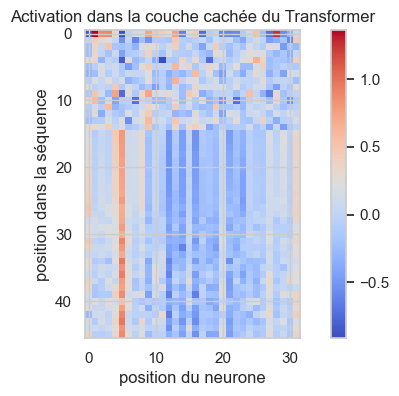

In [24]:
fig, axes = plt.subplots(1, 1, figsize=(8, 4))

im1 = axes.imshow(hidden_acts_transfo, cmap="coolwarm")
plt.xlabel("position du neurone")
plt.ylabel("position dans la séquence")
plt.title(f"Activation dans la couche cachée du Transformer")
fig.colorbar(im1, ax=axes)
plt.show()

##### Les activations cachées du Transformer, pour un élément donné de la séquence

Si on se concentre sur un des éléments :

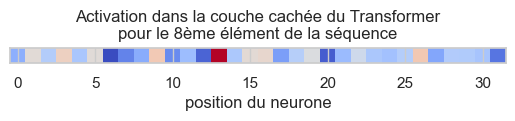

In [25]:
idx_elt_seq = 7
plt.imshow(hidden_acts_transfo[idx_elt_seq].view(1, -1), cmap="coolwarm")
plt.xlabel("position du neurone")
plt.gca().yaxis.set_visible(False)
plt.title(f"Activation dans la couche cachée du Transformer\npour le {idx_elt_seq+1}ème élément de la séquence")
plt.show()

##### Les activations des caractéristiques pour toute la séquence

Maintenant, regardons la succession de ces activations pour la séquence :

**Question :**
Sachant que dans l'image ci-dessous les abscisses représentent les indices des caractérisrtiques, et les ordonnées chaque élément de la séquence. Quelle interprétation peut-on formuler de cette illustration ?

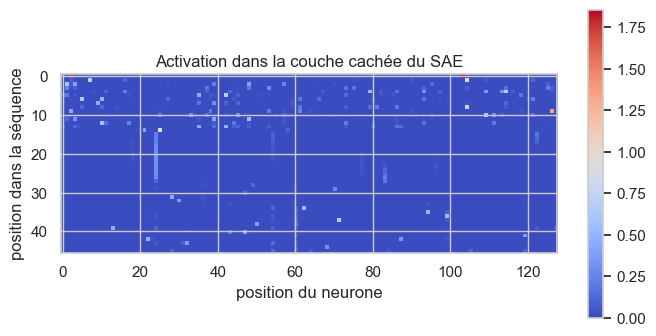

In [26]:
fig, axes = plt.subplots(1, 1, figsize=(8, 4))

im1 = axes.imshow(features, cmap="coolwarm")
plt.xlabel("position du neurone")
plt.ylabel("position dans la séquence")
plt.title("Activation dans la couche cachée du SAE")
fig.colorbar(im1, ax=axes)
plt.show()

##### Les activations des caractéristiques pour un élément d'une séquence donnée

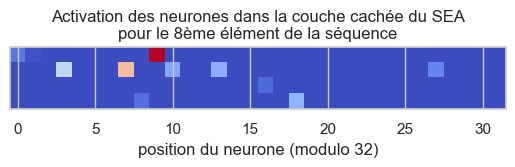

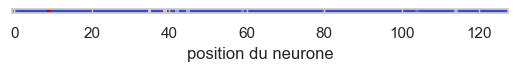

In [27]:
plt.imshow(features[idx_elt_seq].view(4, -1), cmap="coolwarm")
plt.xlabel("position du neurone (modulo 32)")
plt.gca().yaxis.set_visible(False)
plt.title(f"Activation des neurones dans la couche cachée du SEA\npour le {idx_elt_seq+1}ème élément de la séquence")
plt.show()

plt.imshow(features[idx_elt_seq].view(1, -1), cmap="coolwarm")
plt.xlabel("position du neurone")
plt.gca().yaxis.set_visible(False)
plt.show()

##### Les activations successives d'une caractéristique dans le SAE

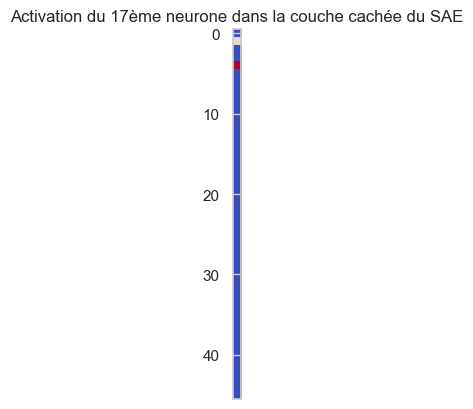

In [28]:
idx_feature = 16
plt.imshow(features[:, idx_feature].view(-1, 1), cmap="coolwarm")
plt.gca().xaxis.set_visible(False)
plt.title(f"Activation du {idx_feature+1}ème neurone dans la couche cachée du SAE")
plt.show()

##### Les activations dans le Transformer et leurs reconstructions :

**Question :**
Sachant que dans l'image ci-dessous les abscisses représentent les indices des activations des neurones cachées dans le Transformer, et les ordonnées chaque élément de la séquence. Quelle interprétation peut-on formuler de cette illustration ?

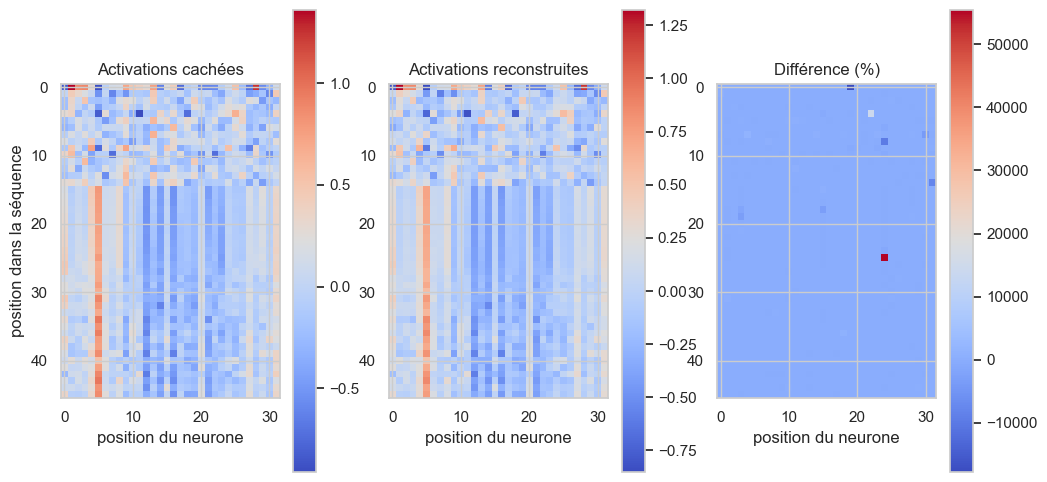

In [29]:
# Exemple de données pour les images
image1 = hidden_acts_transfo.numpy()
image2 = act_recon.numpy()

# Créer une figure avec deux sous-graphiques côte à côte
fig, axes = plt.subplots(1, 3, figsize=(12, 6))

# Afficher la première image
im1 = axes[0].imshow(image1, cmap="coolwarm")
axes[0].set_title('Activations cachées')
axes[0].set_xlabel("position du neurone")
axes[0].set_ylabel("position dans la séquence")
fig.colorbar(im1, ax=axes[0])

# Afficher la deuxième image
im2 = axes[1].imshow(image2, cmap="coolwarm")
axes[1].set_xlabel("position du neurone")
axes[1].set_title('Activations reconstruites')
fig.colorbar(im2, ax=axes[1])

# Afficher la différence
diff = np.abs(image2 - image1) / image1 * 100
im3 = plt.imshow(diff, cmap="coolwarm")
axes[2].set_xlabel("position du neurone")
axes[2].set_title('Différence (%)')
fig.colorbar(im3, ax=axes[2])

# Afficher la figure
plt.show()

Calcul de la perte du modèle de langue en cas d'utilisation des reconstructions à la place des activations initiales.

In [ ]:
total_loss = 0
for i, (X, y) in tqdm(enumerate(train_dataloader), total=len(train_dataloader)):
    X = X.to(device)
    y = y.to(device)

    hidden_acts_transfo = model(X, act=True).view(-1, config.d_model)
    _, act_recon, features, _, _ = sae(hidden_acts_transfo)
    logits = model.get_logits_(act_recon)

    total_loss += F.cross_entropy(
        logits.view(-1, logits.size(-1)),
        y.view(-1).long(),
        ignore_index=tokenizer.char_to_int[PAD]
        )
    #print(i, total_loss.item())

print(f"Train reconstruction loss : {total_loss.item()/len(train_dataloader):.2f}")

clean_memory(device)

  0%|          | 0/2058 [00:00<?, ?it/s]

Train reconstruction loss : 1.95


In [ ]:
total_loss = 0
for i, (X, y) in tqdm(enumerate(test_dataloader), total=len(test_dataloader)):
    X = X.to(device)
    y = y.to(device)

    hidden_acts_transfo = model(X, act=True).view(-1, config.d_model)
    _, act_recon, features, _, _ = sae(hidden_acts_transfo)
    logits = model.get_logits_(act_recon)

    total_loss += F.cross_entropy(
        logits.view(-1, logits.size(-1)),
        y.view(-1).long(),
        ignore_index=tokenizer.char_to_int[PAD]
        )
    #print(i, total_loss.item())

print(f"Test reconstruction loss : {total_loss.item()/len(test_dataloader):.2f}")

clean_memory(device)

  0%|          | 0/229 [00:00<?, ?it/s]

Test reconstruction loss : 1.94


#### Exploration des neurones et concepts

##### Des neurones interprétables ?

On va essayer de découvrir quelles caractéristiques ont été apprises par le modèle, en essayant d'interpréter les neurones d'une des (par défaut dans notre cas, de la...) couches cachées dans le Transformer.

Le principe consiste à préserver les N valeurs d'activation (et les indices de l'entrée alors fournie au modèle) les plus grandes dans des tenseurs nommés `top_values` et `new_values`, grâce à la fonction `update_top_k()`.

![](https://drive.google.com/uc?id=1_YDTcDw3dy57rmOKu3yAI5XF2y_PnHhb)

![SAE activations max](./images/sae_max.png)

Les appels successifs de cette fonction vont permettre de déterminer par paquets/batchs les valeurs d'activations (et leur indice) les plus grandes prises par les neurones cachées dans le Tranformer (cf l'utilisation en dessous).

In [32]:
def update_top_k(
        top_values: torch.Tensor,
        top_indices: torch.Tensor,
        new_values: torch.Tensor,
        new_indices: torch.Tensor,
        k: int) -> Tuple[: torch.Tensor, : torch.Tensor]:
    """
    Args:
        -
    """
    combined_values = torch.cat([top_values, new_values])
    combined_indices = torch.cat([top_indices, new_indices])
    new_top_values, topk_indices = torch.topk(combined_values, k)
    new_top_indices = combined_indices[topk_indices]
    
    return new_top_values, new_top_indices

Exemple d'utilisation de `update_top_k()` :

In [33]:
topK = 2 # Nombre maximum de valeurs à préserver par série
N = 3 # Nombre d'élements distincts dans une série

# Initialisation d'un batch de 4 séries
test_batch = torch.tensor([
    # Elt 0, 1, 2
    [1, 2000, 30],      # serie 0
    [10, 20, 300],      # serie 1
    [1000, 2, 3],       # serie 2
    [100, 200, 3000],   # serie 3
])

# Recherche des topK max par élément distinct, sur les 4 séries du batch, et des indiques des séries
# dans lesquelles la valeur max est présente
top_values = torch.zeros((N, topK), dtype=torch.int32)
top_indices = torch.full((N, topK), -1, dtype=torch.long)
for n in range(N):
    dim_values = test_batch[:, n]
    dim_indices = n + torch.arange(test_batch.size(0))
    print(dim_values)
    top_values[n], top_indices[n] = \
            update_top_k(top_values[n], top_indices[n], dim_values, dim_indices, topK)

expected_top_values = torch.tensor([
    [1000,  100],   # topK valeurs max pour l'élément 0
    [2000,  200],   # topK valeurs max pour l'élément 1
    [3000,  300]    # topK valeurs max pour l'élément 2
    ])
expected_top_indices = torch.tensor([
    [2, 3],         # indices des séries correspondant aux topK de l'élément 0
    [1, 4],         # indices des séries correspondant aux topK de l'élément 1
    [5, 3]          # indices des séries correspondant aux topK de l'élément 2
    ])

print("top_values", top_values)
print("top_indices", top_indices)

assert torch.equal(expected_top_values,  top_values), f"Valeurs inattendues dans top_values"
assert torch.equal(expected_top_indices,  top_indices), f"Valeurs inattendues dans top_indices"

tensor([   1,   10, 1000,  100])
tensor([2000,   20,    2,  200])
tensor([  30,  300,    3, 3000])
top_values tensor([[1000,  100],
        [2000,  200],
        [3000,  300]], dtype=torch.int32)
top_indices tensor([[2, 3],
        [1, 4],
        [5, 3]])


On commence avec des valeurs minimales (`-inf`) et des indices arbitraires ($-1$).

- `top_values`, de taille (nb_neurones_cachés, top_k), répertorie les `top_k` plus grandes valeurs d'activations max de chaque neurone,
- `top_indices`, de taille (nb_neurones_cachés, top_k), répertorie les indices qui correspondent à ces valeurs (indices=indice dans le dataset=indice d'un nom de commune dans le jeu de données d'entrainement)
avec nb_neurones_cachés : nombre de neurones dans la couche concernée du Trasformer, c'est à dire `d_model`.

Pour chaque paquet/batch :<br>
   - on fait passer le batch dans le réseau,<br>
   - on récupère les activations (B, S, nb_neurones_cachés) = nb_acts activations (une activation par neurone) pour chaque élément de séquence (S) pour chaque élément de batch, c.à.d un nom de commune (B),<br>
   - on prend en compte l'activation maximale (selon la position).<br>

Pour chaque neurone :<br>
   - on utilise la fonction `update_top_k` pour mettre à jour `top_values` et `top_indices`.


In [34]:
top_k = 20 # on garde les 20 exemples qui font s'activer le plus chaque neurone caché du Transformer

# Les plus petites valeurs possibles
top_values = torch.full((config.d_model, top_k), -float('inf'))
# indices à -1 (le dernier) du fait que les plus petites valeurs seront classées en dernier dans top_vales
top_indices = torch.full((config.d_model, top_k), -1, dtype=torch.long)

#Pour chaque élément du jeu de données d'entrainement
for X, _ in tqdm(train_dataloader, total=len(train_dataloader)):
    # par lot
    X = X.to(device)
    # récupération des activations cachées du Transformer
    hidden_acts_transfo = model(X, act=True) # (B, L, d_model)
    # transfert vers le "cpu"
    hidden_acts_transfo = hidden_acts_transfo.to("cpu")
    # récupération la valeur maximale d'activation de chaque neurone cachée dans le Transformer, par batch
    max_act = hidden_acts_transfo.max(dim=1).values # (B, d_model)

    # pour chaque neurone caché du Transformer
    for id_neuron in range(config.d_model):
        # récupérer l'ensemble des valeurs d'activation de ce neurone
        dim_values = max_act[:, id_neuron]
        # calcul des indices pour chaque valeur d'activation (rappel: une par élément de batch)
        dim_indices = id_neuron + torch.arange(train_dataloader.batch_size)

        # compilation des valeurs d'activations maximum selon l'indice du nom de commune dans le jeu de données d'entrainement
        top_values[id_neuron], top_indices[id_neuron] = \
            update_top_k(top_values[id_neuron], top_indices[id_neuron], dim_values, dim_indices, top_k)

clean_memory(device)

  0%|          | 0/2058 [00:00<?, ?it/s]

Récupération des k neurones cachés du Transformer ayant les plus fortes activations, et les indices (dans jeu d'entrainement) des noms de communes associées.

In [35]:
max_activations, indices = top_values[:, 0].topk(k=25)
print("valeurs maximales : ", max_activations.tolist())
print("indices des neurones correspondants : ", indices.tolist())
max_activations_indices = top_indices[indices][0].tolist()
print("indices des noms de communes dans le jeu d'entrainement", max_activations_indices)

valeurs maximales :  [1.5651806592941284, 1.3993204832077026, 1.3585578203201294, 1.303451418876648, 1.2444312572479248, 1.1987457275390625, 1.191386103630066, 1.139875054359436, 1.0982507467269897, 1.071806788444519, 1.0295617580413818, 1.0245229005813599, 1.0059754848480225, 0.9905542135238647, 0.8872393369674683, 0.8841606974601746, 0.866046667098999, 0.84597247838974, 0.8375204801559448, 0.7957645058631897, 0.7736837863922119, 0.698220431804657, 0.6970276236534119, 0.6884750723838806, 0.6793059706687927]
indices des neurones correspondants :  [4, 9, 1, 13, 28, 5, 19, 24, 15, 8, 25, 10, 26, 16, 3, 11, 2, 17, 0, 6, 31, 20, 21, 12, 18]
indices des noms de communes dans le jeu d'entrainement [15, 8, 11, 9, 16, 14, 10, 10, 6, 7, 19, 19, 7, 8, 16, 14, 19, 12, 4, 16]


Pour un neurone caché choisi via son indice dans [0; `d_model`-1], on affiche les `topK` noms de communes liés aux plus grandes valeurs d'activation détectées.

In [ ]:
id_hidden_activation = indices[0]
for i in top_indices[id_hidden_activation]:
    data_i, _ = train_dataset[i.item()]
    data_i = data_i.to(device)
    city_name = tokenizer.to_string(data_i.tolist())
    data_i = data_i.unsqueeze(0)
    hidden_acts_transfo = model(data_i, act=True) # (B, L, n_neurones)
    print_color(city_name, hidden_acts_transfo[0, :, id_hidden_activation].tolist()[:len(city_name)])

clean_memory(device)

Essayez avec différents neurones, en vous concentrant sur ceux ayant obtenu les plus grandes valeurs d'activation sur l'ensemble des neurones, de trouver des concepts explicites si cela est possible. Si oui, alors vous avez trouvé des neurones "monosémantique", sinon, vous constatetez leur caractère "polysémantique".

##### EXERCICE(S) : Concepts interprétables grâce au SAE ?

Le principe est exactement le même qu'avec les neurones de la couche cachée dans le Transformer, mais on regarde maintenant dans l'espace des activations du SAE avec les neurones de la couche cachée du SAE.

Retrouver les plus grandes valeurs d'activation des neurones cachés du SEA nn modifiant légèrement le code utilisé pour trouver celles des neurones cachés du Transformer,  

<details> 
<summary>Eléments d'énoncé</summary>

```python
# Les plus petites valeurs possibles
top_values_sae = torch.full((sae.num_features, top_k), -float('inf'))
# indices à -1 (le dernier) du fait que les plus petites valeurs seront classées en dernier dans top_values_sae
top_indices_sae = torch.full((sae.num_features, top_k), -1, dtype=torch.long)

#Pour chaque élément du jeu de données d'entrainement
for X, _ in tqdm(train_dataloader, total=len(train_dataloader)):
    # par lot
    X = X.to(device)

    ### EXERCICE : compléter ce bloc avec les bonnes instructions 
    # DEBUT DE BLOC
    
    ### EXERCICE : à compléter

    # FIN DE BLOC

clean_memory(device)
````
</details>

> Solution(s) :

In [37]:
top_k = 20 # on garde les 20 exemples qui font s'activer le plus chaque neurone caché du Transformer

# Les plus petites valeurs possibles
top_values_sae = torch.full((sae.num_features, top_k), -float('inf'))
# indices à -1 (le dernier) du fait que les plus petites valeurs seront classées en dernier dans top_values_sae
top_indices_sae = torch.full((sae.num_features, top_k), -1, dtype=torch.long)

#Pour chaque élément du jeu de données d'entrainement
for X, _ in tqdm(train_dataloader, total=len(train_dataloader)):
    # par lot
    X = X.to(device)
    # récupération des activations cachées du Transformer
    hidden_acts_transfo = model(X, act=True) # (B, S, d_model)
    # récupération des activations de caractéristiques (features) correspondant
    _, _, features, _, _ = sae(hidden_acts_transfo)
    # récupération la valeur maximale d'activation de chaque caractéristique dans le SAE, par batch
    max_features = features.max(dim=1).values # (B, S, num_features)
    # transfert vers le "cpu"
    max_features = max_features.to("cpu")
    
     # pour chaque caractéristique gérée par le SAE
    for id_feature in range(sae.num_features):
        # récupérer l'ensemble des valeurs d'activation de cette caractéristique
        dim_values = max_features[:, id_feature]
        # calcul des indices pour chaque valeur d'activation (rappel: une par élément de batch)
        dim_indices = id_feature + torch.arange(train_dataloader.batch_size)

        # compilation des valeurs d'activations maximum selon l'indice du nom de commune dans le jeu de données d'entrainement
        top_values_sae[id_feature], top_indices_sae[id_feature] = \
            update_top_k(top_values_sae[id_feature], top_indices_sae[id_feature], dim_values, dim_indices, top_k)

clean_memory(device)

  0%|          | 0/2058 [00:00<?, ?it/s]

Récupération des k neurones cachés du SAE ayant les plus fortes activations, et les indices (dans le jeu d'entrainement) des noms de communes associées.

In [38]:
max_activations_sae, indices_sae = top_values_sae[:, 0].topk(k=20)
print("valeurs maximales : ", max_activations_sae.tolist())
print("indices des caractéristiques correspondantes : ", indices_sae.tolist())
max_activations_indices_sae = top_indices_sae[indices][0].tolist()
print("indices des noms de communes dans le jeu d'entrainement", max_activations_indices_sae)

valeurs maximales :  [2.9628729820251465, 1.8575928211212158, 1.8442227840423584, 1.8349063396453857, 1.8114523887634277, 1.808037281036377, 1.7582805156707764, 1.6861567497253418, 1.617019772529602, 1.5313050746917725, 1.4496736526489258, 1.1450605392456055, 1.039113998413086, 0.9889669418334961, 0.96208256483078, 0.9602310657501221, 0.9555763602256775, 0.9514310359954834, 0.9399889707565308, 0.9345197677612305]
indices des caractéristiques correspondantes :  [126, 103, 120, 104, 109, 61, 2, 25, 123, 37, 42, 10, 79, 87, 39, 62, 57, 35, 114, 71]
indices des noms de communes dans le jeu d'entrainement [9, 13, 9, 12, 12, 14, 11, 12, 12, 16, 8, 13, 8, 4, 16, 4, 18, 12, 8, 8]


In [ ]:
idx_feature = indices_sae[0]
for i in top_indices_sae[idx_feature]:
    data_i, _ = train_dataset[i.item()]
    data_i = data_i.to(device)
    city_name = tokenizer.to_string(data_i.tolist())
    data_i = data_i.unsqueeze(0)
    hidden_acts_transfo = model(data_i, act=True) # (B, S, n_features)
    _, _, features, _, _ = sae(hidden_acts_transfo)
    print_color(city_name, features[0, :, idx_feature].tolist()[:len(city_name)])

clean_memory(device)